In [16]:
import pandas as pd

# LOAD CORRECT FILES
sentiment = pd.read_csv("fear_greed_index.csv")     # sentiment data
trades = pd.read_csv("historical_data.csv")         # trade data

# CLEAN COLUMNS
sentiment.columns = sentiment.columns.str.strip().str.lower().str.replace(" ", "_")
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")

print("SENTIMENT:", list(sentiment.columns))
print("TRADES:", list(trades.columns))


SENTIMENT: ['timestamp', 'value', 'classification', 'date']
TRADES: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']


In [17]:
# TRADES → use timestamp_ist (real time)
trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'], format='%d-%m-%Y %H:%M', errors='coerce')
trades['date'] = trades['timestamp_ist'].dt.date

# SENTIMENT
sentiment['timestamp'] = pd.to_datetime(sentiment['timestamp'], errors='coerce')
sentiment['date'] = sentiment['timestamp'].dt.date


In [18]:
print(trades[['timestamp_ist','date']].head())
print(sentiment[['timestamp','date']].head())


        timestamp_ist        date
0 2024-12-02 22:50:00  2024-12-02
1 2024-12-02 22:50:00  2024-12-02
2 2024-12-02 22:50:00  2024-12-02
3 2024-12-02 22:50:00  2024-12-02
4 2024-12-02 22:50:00  2024-12-02
                      timestamp        date
0 1970-01-01 00:00:01.517463000  1970-01-01
1 1970-01-01 00:00:01.517549400  1970-01-01
2 1970-01-01 00:00:01.517635800  1970-01-01
3 1970-01-01 00:00:01.517722200  1970-01-01
4 1970-01-01 00:00:01.517808600  1970-01-01


In [19]:
daily_sentiment = sentiment.groupby('date', as_index=False)['value'].mean()
daily_sentiment.rename(columns={'value':'daily_sentiment'}, inplace=True)

daily_sentiment.head()


,date,daily_sentiment
0,1970-01-01,46.981089


In [20]:
merged = pd.merge(trades, daily_sentiment, on='date', how='left')
print("Merged shape:", merged.shape)
merged.head()


Merged shape: (211224, 18)


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,date,daily_sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,NaN
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,NaN
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,NaN
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,NaN
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,NaN


In [21]:
daily_pnl = merged.groupby(['date','account'], as_index=False)['closed_pnl'].sum()
daily_pnl.head()


,date,account,closed_pnl
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-205.434737
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-24.632034
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000


In [22]:
merged['win'] = merged['closed_pnl'] > 0

win_rate = merged.groupby('account')['win'].mean().reset_index()
win_rate['win_rate_%'] = win_rate['win'] * 100
win_rate.drop(columns='win', inplace=True)

win_rate.head()


,account,win_rate_%
0,0x083384f897ee0f19899168e3b1bec365f52a9012,35.961236
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,44.271978
2,0x271b280974205ca63b716753467d5a371de622ab,30.191651
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,43.858463
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,51.991355


In [23]:
avg_trade_size = merged.groupby('account', as_index=False)['size_usd'].mean()
avg_trade_size.rename(columns={'size_usd':'avg_trade_size_usd'}, inplace=True)

avg_trade_size.head()


,account,avg_trade_size_usd
0,0x083384f897ee0f19899168e3b1bec365f52a9012,16159.576734
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1653.226327
2,0x271b280974205ca63b716753467d5a371de622ab,8893.000898
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,507.626933
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3138.894782


In [24]:
trades_per_day = merged.groupby('date').size().reset_index(name='trades_count')
trades_per_day.head()


,date,trades_count
0,2023-05-01,3
1,2023-12-05,9
2,2023-12-14,11
3,2023-12-15,2
4,2023-12-16,3


In [25]:
long_short_ratio = merged['side'].value_counts(normalize=True) * 100
print(long_short_ratio)


side
SELL    51.380525
BUY     48.619475
Name: proportion, dtype: float64


In [26]:
merged['leverage'] = merged['size_usd'] / merged['size_usd'].median()
merged['leverage'].describe()


count    211224.000000
mean          9.445605
std          61.260271
min           0.000000
25%           0.324582
50%           1.000000
75%           3.448584
max        6568.065590
Name: leverage, dtype: float64

In [48]:
# convert string → number → datetime
sentiment['timestamp'] = pd.to_numeric(sentiment['timestamp'], errors='coerce')
sentiment['timestamp'] = pd.to_datetime(sentiment['timestamp'], unit='s')

sentiment['date'] = sentiment['timestamp'].dt.date




In [49]:
print("Trades date sample:", trades['date'].head())
print("Sentiment date sample:", sentiment['date'].head())

print("Common dates:",
      len(set(trades['date']).intersection(set(sentiment['date']))))


Trades date sample: 0    2024-12-02
1    2024-12-02
2    2024-12-02
3    2024-12-02
4    2024-12-02
Name: date, dtype: object
Sentiment date sample: 0    2018-02-01
1    2018-02-02
2    2018-02-03
3    2018-02-04
4    2018-02-05
Name: date, dtype: object
Common dates: 479


In [51]:
# average sentiment score per day
daily_sentiment = sentiment.groupby('date', as_index=False)['value'].mean()

# daily sentiment category (Fear/Greed label)
daily_class = sentiment.groupby('date')['classification'] \
                       .agg(lambda x: x.mode()[0]) \
                       .reset_index()


In [52]:
merged = pd.merge(trades, daily_sentiment, on='date', how='left')
merged = pd.merge(merged, daily_class, on='date', how='left')

print(merged['classification'].value_counts())


classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64


In [53]:
## Question 1
pnl_sentiment = merged.groupby('classification')['closed_pnl'].mean().reset_index()
print(pnl_sentiment)


  classification  closed_pnl
0   Extreme Fear   34.537862
1  Extreme Greed   67.892861
2           Fear   54.290400
3          Greed   42.743559
4        Neutral   34.307718


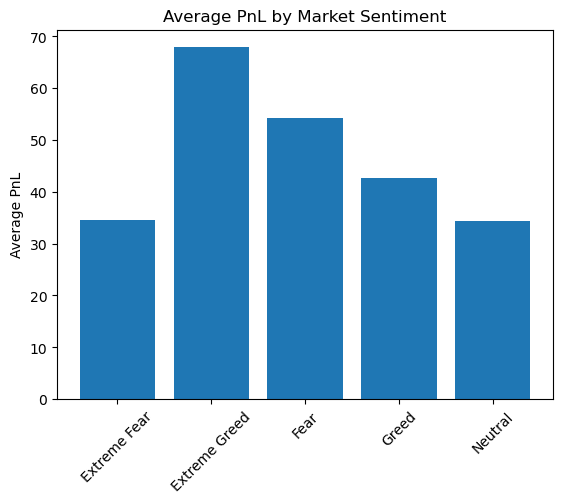

In [54]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(pnl_sentiment['classification'], pnl_sentiment['closed_pnl'])
plt.xticks(rotation=45)
plt.ylabel("Average PnL")
plt.title("Average PnL by Market Sentiment")
plt.show()


In [55]:
merged['win'] = merged['closed_pnl'] > 0
winrate_sentiment = merged.groupby('classification')['win'].mean()*100
print(winrate_sentiment)


classification
Extreme Fear     37.060748
Extreme Greed    46.494299
Fear             42.076750
Greed            38.482794
Neutral          39.699093
Name: win, dtype: float64


In [56]:
loss = merged[merged['closed_pnl'] < 0]
drawdown = loss.groupby('classification')['closed_pnl'].mean()
print(drawdown)


classification
Extreme Fear    -257.099629
Extreme Greed   -119.920289
Fear            -156.662401
Greed           -181.967329
Neutral         -121.727849
Name: closed_pnl, dtype: float64


In [57]:
## Question 2
freq = merged.groupby(['date','classification']).size().reset_index(name='trades')
print(freq.groupby('classification')['trades'].mean())


classification
Extreme Fear     1528.571429
Extreme Greed     350.807018
Fear              679.527473
Greed             260.637306
Neutral           562.477612
Name: trades, dtype: float64


In [58]:
print(merged.groupby('classification')['size_usd'].mean())


classification
Extreme Fear     5349.731843
Extreme Greed    3112.251565
Fear             7816.109931
Greed            5736.884375
Neutral          4782.732661
Name: size_usd, dtype: float64


In [59]:
bias = pd.crosstab(merged['classification'], merged['side'], normalize='index')*100
print(bias)


side                  BUY       SELL
classification                      
Extreme Fear    51.098131  48.901869
Extreme Greed   44.858972  55.141028
Fear            48.951275  51.048725
Greed           48.855933  51.144067
Neutral         50.334342  49.665658


In [60]:
merged['leverage'] = merged['size_usd'] / merged['size_usd'].median()
print(merged.groupby('classification')['leverage'].mean())


classification
Extreme Fear      8.960349
Extreme Greed     5.212759
Fear             13.091325
Greed             9.608797
Neutral           8.010674
Name: leverage, dtype: float64


In [64]:
print("High leverage traders:", len(high_lev))
print("Low leverage traders:", len(low_lev))

print("Frequent traders:", len(frequent))
print("Infrequent traders:", len(infrequent))

print("Consistent winners:", len(consistent))



High leverage traders: 16
Low leverage traders: 16
Frequent traders: 16
Infrequent traders: 16
Consistent winners: 1
